In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Read in the data

In [25]:
census_colname = 'ONS_Census_2011'
TARGET_COLNAME = 'Presented_Normalised'
target_colname = 'tempPresHS2014_1624'
#arget_colname = '{0}'.format(TARGET_COLNAME)
population_colname = 'pop_2014_1624'
population_total_colname = 'total_pop_2014'

In [26]:
DATA_RAW = pd.read_csv('../source data/new data/dataset for ADAM 13 Aug 2015.csv')
mask = ((DATA_RAW[census_colname].str[:2] == 'E0') + (DATA_RAW[census_colname].str[:2] == 'W0'))
DATA_ENG_WAL_RAW = DATA_RAW[mask]
DATA_ENG_WAL = DATA_ENG_WAL_RAW[DATA_ENG_WAL_RAW[census_colname].notnull()]

# "test" subset — all records with known ONS codes
data_eng = DATA_ENG_WAL.copy()
#kick out the outlier: Milton Keynes
data_eng = data_eng[data_eng[census_colname] != 'E06000042']

/home/adam/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:190: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [27]:
data_eng['Presented_Normalised'] = data_eng[target_colname]/data_eng[population_colname]
predictors = [population_colname]
test_filled = data_eng.dropna(subset=predictors, how='any')
train_filled = test_filled.dropna(subset=[target_colname])

### Linear Model based on Young Population - the only variable which is (obviously) correlated

#### All data

In [28]:
import statsmodels.formula.api as sm
model1 = sm.ols(formula="{0} ~ {1}".format(target_colname, ' + '.join([population_colname])), data=train_filled).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     tempPresHS2014_1624   R-squared:                       0.455
Model:                             OLS   Adj. R-squared:                  0.451
Method:                  Least Squares   F-statistic:                     133.4
Date:                 Sat, 15 Aug 2015   Prob (F-statistic):           7.92e-23
Time:                         10:22:50   Log-Likelihood:                -1134.1
No. Observations:                  162   AIC:                             2272.
Df Residuals:                      160   BIC:                             2278.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -4.0080     29.133     -0.138      0.891       -61.542    53.526
pop_2014_1624     0.0127      0.001     11.550      0.000         0.011     0.015
==============================================================================
Omnibus:                       98.134   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              715.501
Skew:                           2.127   Prob(JB):                    4.28e-156
Kurtosis:                      12.376   Cond. No.                     3.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Error estimation

See [here](http://stats.stackexchange.com/a/166949/71858) for the explanation of error estimation. I first calculate the standard deviation on the training data:
$$\hat{\sigma} = \sqrt{\frac{\sum (y-\hat{y})^2}{N-2}}$$

Then my upper and lower bounds for the **sum of homeless persons** are:
$$S=\sum (\hat{y}\pm 2\hat{\sigma})$$

Negative estimations don't make much sense, so for the lower bound, I'm taking $max(0, \hat{y}-2\hat{\sigma})$ (all the predictions that are below zero are zeroed).

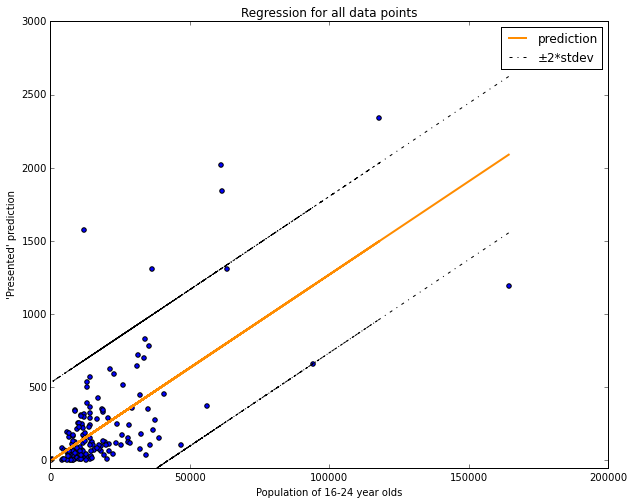

In [29]:
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize'] = (10, 8)

predictor = population_colname
clf = LinearRegression()
clf.fit(train_filled[predictors], train_filled[target_colname])

prediction = clf.predict(train_filled[predictors])
stdev = np.sqrt(sum((train_filled[target_colname]-prediction)**2)/(len(prediction)-2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_filled[predictor], train_filled[target_colname])
ax.plot(train_filled[predictor], prediction, color='darkorange', lw=2, label='prediction')
ax.plot(train_filled[predictor], prediction+2*stdev, color='black', lw=1, ls='-.')
ax.plot(train_filled[predictor], prediction-2*stdev, color='black', lw=1, ls='-.', label='±2*stdev')
ax.set_xbound(lower=-50)
ax.set_ybound(lower=-50)
ax.legend(loc='best')
ax.set_ylabel("'Presented' prediction")
ax.set_xlabel("Population of 16-24 year olds")

ax.set_title('Regression for all data points')

#### Run the prediction on all data

After running the model, cerate upper/lower bound columns and save the results to a .csv file.

In [31]:
test_filled['prediction'] = clf.predict(test_filled[[population_colname]])
test_filled['prediction_processed'] = test_filled[target_colname].fillna(test_filled['prediction'])
test_filled['prediction_upper_bound'] = test_filled[target_colname].fillna(test_filled['prediction'].apply(lambda x: max(0, x+2*stdev)))
test_filled['prediction_lower_bound'] = test_filled[target_colname].fillna(test_filled['prediction'].apply(lambda x: max(0, x-2*stdev)))
test_filled.to_csv('linear_prediction_alldata.csv', columns=['ONS_Census_2011', 'Local_Authority', 'prediction_lower_bound', 'prediction_upper_bound', 'prediction', target_colname])
test_filled[['prediction_lower_bound', 'prediction_upper_bound', 'prediction', target_colname]].head(10)

,prediction_lower_bound,prediction_upper_bound,prediction,tempPresHS2014_1624
0,1195,1195.000000,2089.512543,1195
1,353,353.000000,233.329151,353
2,0,1020.500181,486.273075,NaN
3,1307,1307.000000,460.117445,1307
4,288,288.000000,177.628998,288
5,453,453.000000,514.339735,453
6,661,661.000000,1193.851025,661
7,243,243.000000,178.622733,243
8,0,936.771589,402.544483,NaN
9,284,284.000000,208.154516,284


### Final prediction

In [32]:
test_filled[['prediction_lower_bound', 'prediction_upper_bound', 'prediction', target_colname]].sum()

prediction_lower_bound     39754.587251
prediction_upper_bound    180962.257513
prediction                 82130.242901
tempPresHS2014_1624        37159.000000
dtype: float64

#### "Reliable" data

Copy exactly what was done above, but take only those authorities for which the franction of presented is > 0.005 for building the model.

In [34]:
mask = train_filled['Presented_Normalised'] > 0.005
import statsmodels.formula.api as sm
model2 = sm.ols(formula="{0} ~ {1}".format(target_colname, ' + '.join([population_colname])), data=train_filled[mask]).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     tempPresHS2014_1624   R-squared:                       0.479
Model:                             OLS   Adj. R-squared:                  0.474
Method:                  Least Squares   F-statistic:                     94.53
Date:                 Sat, 15 Aug 2015   Prob (F-statistic):           3.06e-16
Time:                         10:25:13   Log-Likelihood:                -746.32
No. Observations:                  105   AIC:                             1497.
Df Residuals:                      103   BIC:                             1502.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        74.1536     39.537      1.876      0.064        -4.260   152.567
pop_2014_1624     0.0127      0.001      9.723      0.000         0.010     0.015
==============================================================================
Omnibus:                       57.252   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.713
Skew:                           1.764   Prob(JB):                     2.71e-59
Kurtosis:                      10.015   Cond. No.                     4.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

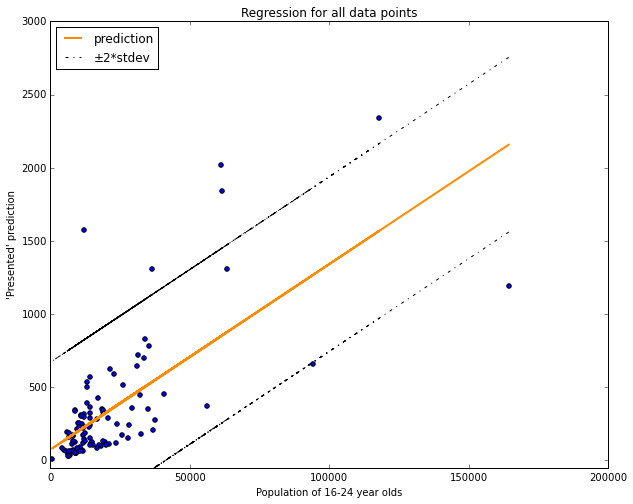

In [36]:
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize'] = (10, 8)

predictor = population_colname
clf2 = LinearRegression()
clf2.fit(train_filled[mask][predictors], train_filled[mask][target_colname])

prediction = clf2.predict(train_filled[mask][predictors])
stdev = np.sqrt(sum((train_filled[mask][target_colname]-prediction)**2)/(len(prediction)-2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_filled[mask][predictor], train_filled[mask][target_colname])
ax.plot(train_filled[mask][predictor], prediction, color='darkorange', lw=2, label='prediction')
ax.plot(train_filled[mask][predictor], prediction+2*stdev, color='black', lw=1, ls='-.')
ax.plot(train_filled[mask][predictor], prediction-2*stdev, color='black', lw=1, ls='-.', label='±2*stdev')
ax.set_xbound(lower=-50)
ax.set_ybound(lower=-50)
ax.legend(loc='best')
ax.set_ylabel("'Presented' prediction")
ax.set_xlabel("Population of 16-24 year olds")

ax.set_title('Regression for all data points')

In [39]:
test_filled['prediction_topdata'] = clf.predict(test_filled[[population_colname]])
test_filled['prediction_processed_topdata'] = test_filled[target_colname].fillna(test_filled['prediction_topdata'])
test_filled['prediction_upper_bound_topdata'] = test_filled[target_colname].fillna(test_filled['prediction_topdata'].apply(lambda x: max(0, x+2*stdev)))
test_filled['prediction_lower_bound_topdata'] = test_filled[target_colname].fillna(test_filled['prediction_topdata'].apply(lambda x: max(0, x-2*stdev)))
test_filled.to_csv('linear_prediction_topdata.csv', columns=['ONS_Census_2011', 'Local_Authority', 'prediction_lower_bound_topdata', 'prediction_upper_bound_topdata', 'prediction_topdata', target_colname])
test_filled[['prediction_lower_bound_topdata', 'prediction_upper_bound_topdata', 'prediction_topdata', target_colname]].head(10)

,prediction_lower_bound_topdata,prediction_upper_bound_topdata,prediction_topdata,tempPresHS2014_1624
0,1195,1195.000000,2089.512543,1195
1,353,353.000000,233.329151,353
2,0,1083.102009,486.273075,NaN
3,1307,1307.000000,460.117445,1307
4,288,288.000000,177.628998,288
5,453,453.000000,514.339735,453
6,661,661.000000,1193.851025,661
7,243,243.000000,178.622733,243
8,0,999.373417,402.544483,NaN
9,284,284.000000,208.154516,284


In [41]:
test_filled[['prediction_lower_bound_topdata', 'prediction_upper_bound_topdata', 'prediction_topdata', target_colname]].sum()

prediction_lower_bound_topdata     39130.765758
prediction_upper_bound_topdata    192543.595666
prediction_topdata                 82130.242901
tempPresHS2014_1624                37159.000000
dtype: float64